##***중요***

train과 test 디렉토리 경로를 설정하는 부분의 코드가 수정되었습니다.<br>
해당 부분에 TODO가 추가되었으니 이 부분도 함께 살펴주세요 :)

이번 과제는 ResNet으로 개와 고양이 classification을 하는 task 입니다.

주석이 많이 달려있으니 하나하나 꼼꼼히 읽어보면서 꼭 모든 내용을 이해해보길 바랍니다!

**주의: 반드시 본인의 google Drive 혹은 로컬에에 복제한 후 수정하세요!**

**교육세션 공유 파일에 올라온 ipynb 파일은 수정하면 안 됩니다!**

# Deep Residual Networks (Resnet)

Reference:

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

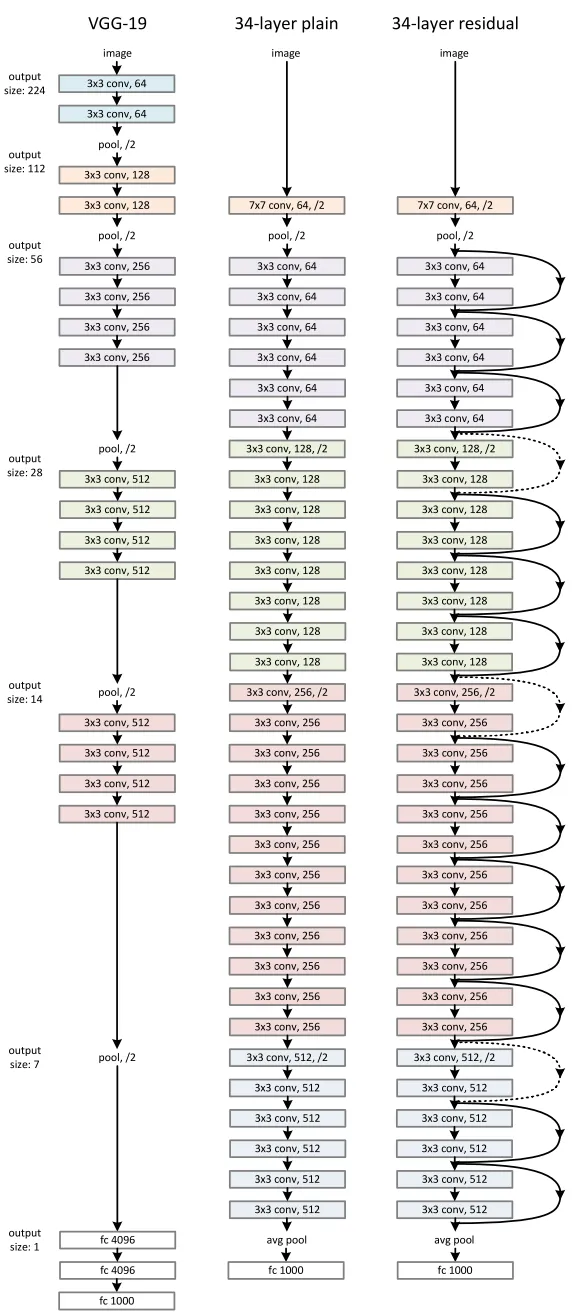

https://arxiv.org/pdf/1512.03385.pdf

CNN은 이미지 인식 분야에서 뛰어난 성능을 보이며, 네트워크의 레이어를 깊이 쌓아 성능을 향상시키고 있습니다. 그러나 실제로 레이어를 깊게 쌓으면 기울기 소실 문제로 인해 성능이 저하될 수 있습니다. 레이어가 깊어질수록 역전파 과정에서 얻어지는 기울기가 너무 작아지거나 커지면서 문제가 발생하는 것입니다.

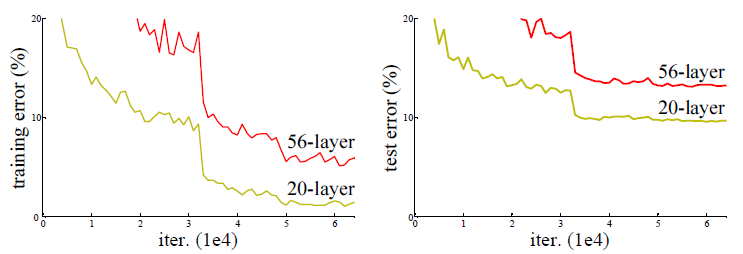

더 깊은 신경망이 더 좋은 성능을 내기 위해 딥 레지듀얼 러닝(ResNet)이 제안되었습니다. 앞서 언급한 문제를 해결하기 위해, ResNet은 Residual Learning 방법을 사용합니다.

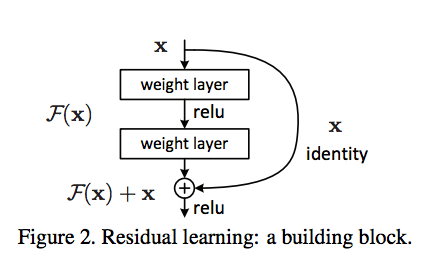

## Step 0. Data 불러오기

reference: https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
from google.colab import drive
import zipfile
import os

In [2]:
#Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Zip 파일 경로 설정
# TODO: 실제 train.zip과 test.zip이 있는 경로를 입력해주세요.
# 예: /content/drive/MyDrive/data/train.zip
train_zip_path = '/content/drive/MyDrive/train.zip'
test_zip_path = '/content/drive/MyDrive/test.zip'

# 압축 해제할 경로 설정
train_extract_to_path = './0725-DL'
test_extract_to_path = './0725-DL'

# 파일 존재 여부 확인
if not os.path.exists(train_zip_path):
    print(f"Train zip file not found at: {train_zip_path}")
if not os.path.exists(test_zip_path):
    print(f"Test zip file not found at: {test_zip_path}")


# 압축 해제할 디렉토리가 존재하지 않으면 생성
if not os.path.exists(train_extract_to_path):
    os.makedirs(train_extract_to_path)
if not os.path.exists(test_extract_to_path):
    os.makedirs(test_extract_to_path)

In [4]:
# Zip 파일 압축 해제 함수
def unzip_file(zip_path: str, extract_to_path: str) -> str:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

    print(f"Zip file {zip_path} extracted successfully!")

# Train 및 test zip 파일 압축 해제 (시간이 오래 걸릴 수 있어요!)
unzip_file(train_zip_path, train_extract_to_path)
unzip_file(test_zip_path, test_extract_to_path)

Zip file /content/drive/MyDrive/train.zip extracted successfully!
Zip file /content/drive/MyDrive/test.zip extracted successfully!


In [5]:
train_dir = os.path.join(train_extract_to_path, 'train')
test_dir  = os.path.join(test_extract_to_path, 'test')

print(f"Training data directory: {train_dir}")
print(f"Test data directory: {test_dir}")

Training data directory: ./0725-DL/train
Test data directory: ./0725-DL/test


## Step 1. Data Preporcessing

모든 모델링의 필수 단계인 전처리 입니다. 여러분들에게 주어진 이미지는 각자 크기가 다 다르므로 이를 통일시켜줄 필요가 있다는 점을 유념해주세요.



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from typing import Any, Tuple, Optional, List

In [7]:
# Data Preprocessing function
def data_preprocessing(data_dir: str, transform: Any = None) -> Dataset:
    """
    Applies preprocessing transformations to the dataset.

    Args:
        data_dir (str): Directory where the data is stored.
        transform (Any): Transformations to apply to the data.

    Returns:
        Dataset: Preprocessed dataset.
    """
    return datasets.ImageFolder(root=data_dir, transform=transform)

In [8]:
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Apply preprocessing to the datasets
train_dataset = data_preprocessing(train_dir, transform_train)
test_dataset = data_preprocessing(test_dir, transform=transform_test)


### class distribution

visualize_class_distribution(train_dataset, train_dataset.classes)을 실행시켜 보면 주어진 train data가 엄청나게 편향되어 있다는 것을 쉽게 발견할 수 있습니다.

data의 편향은 모델의 성능에 큰 악영향을 미칩니다. 이를 해결하기 위해 downsampling을 해보세요.


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader
from tqdm import tqdm

In [10]:
# Downsampling Function
def downsample_class(dataset: Dataset, target_class: int, ratio: float, batch_size: int = 64) -> Dataset:
    """
    특정 클래스를 주어진 비율로 다운샘플링합니다.

    Args:
        dataset (Dataset): 다운샘플링할 데이터셋.
        target_class (int): 다운샘플링할 클래스
        ratio (float): 다운샘플링할 비율 (예: 0.1은 10%).
        batch_size (int): 데이터 로드 배치 크기.

    Returns:
        Dataset: 다운샘플링된 데이터셋.
    """
    target_indices = []
    other_indices = []

    # DataLoader를 사용하여 배치 단위로 데이터 로드
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch_idx, (inputs, targets) in tqdm(enumerate(data_loader), desc="Collecting indices", total=len(data_loader)):
        for i, y in enumerate(targets):
            index = batch_idx * batch_size + i
            if y == target_class:
                target_indices.append(index)
            else:
                other_indices.append(index)

    np.random.shuffle(target_indices)

    downsampled_size = int(len(target_indices) * ratio)

    # 처음 'downsampled_size' 개의 인덱스를 선택
    downsampled_target_indices = target_indices[:downsampled_size]

    # 다른 클래스의 인덱스와 합침
    final_indices = downsampled_target_indices + other_indices

    # 최종 인덱스를 무작위로 섞음
    np.random.shuffle(final_indices)

    # 다운샘플링된 인덱스를 사용하여 데이터셋의 서브셋을 반환
    return Subset(dataset, final_indices)

In [11]:
def visualize_class_distribution(dataset: datasets.ImageFolder or Subset, classes: list) -> None:
    if isinstance(dataset, Subset):
        labels = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        labels = [label for _, label in dataset]

    class_counts = Counter(labels)

    plt.figure(figsize=(12, 6))
    plt.bar(classes, [class_counts[i] for i in range(len(classes))])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution in the dataset')
    plt.xticks(rotation=45)
    plt.show()
    print(f"Class counts: {class_counts}")

Original class distribution in the training dataset:


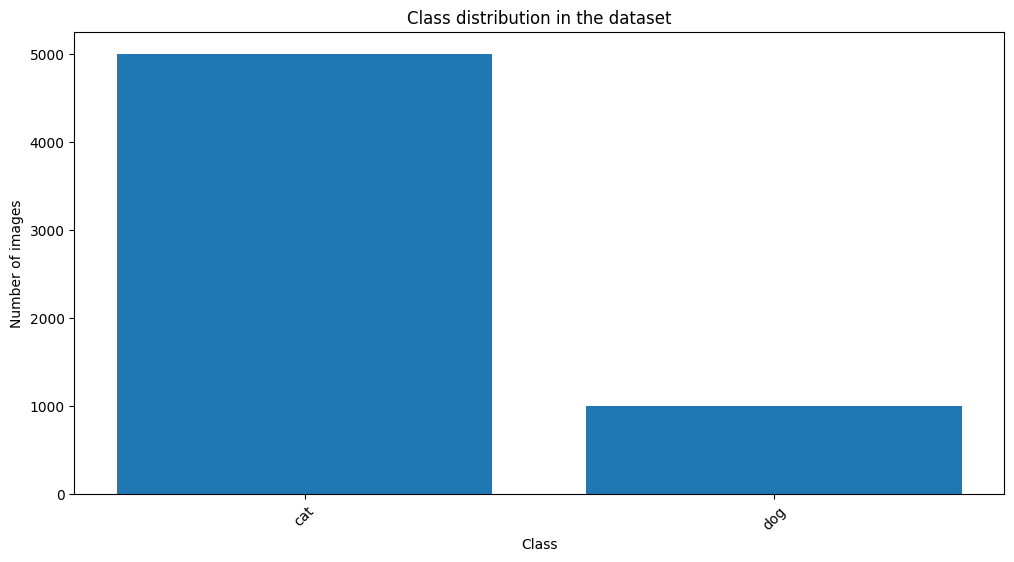

Class counts: Counter({0: 5000, 1: 1000})


In [12]:
print("Original class distribution in the training dataset:")
visualize_class_distribution(train_dataset, train_dataset.classes)

In [13]:
# Downsample the datasets
from collections import Counter

# 1) 각 클래스별 샘플 수 집계 → 가장 많은(majority) 클래스 선택
counts = Counter(train_dataset.targets)
major_class = counts.most_common(1)[0][0]
ratio = 0.2

# 2) 다운샘플링 실행
downsampled_train_dataset = downsample_class(
    train_dataset,
    target_class=major_class,
    ratio=ratio,
    batch_size=64
)

Class distribution in the downsampled training dataset:


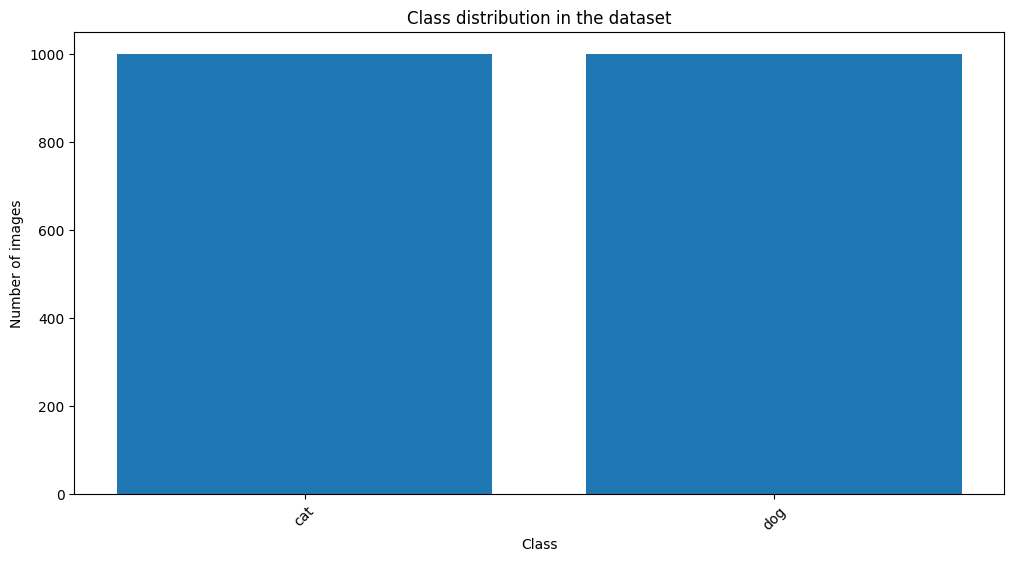

Class counts: Counter({1: 1000, 0: 1000})


In [14]:
print("Class distribution in the downsampled training dataset:")
visualize_class_distribution(downsampled_train_dataset, train_dataset.classes)
#시간이 오래 걸릴 수 있어요!

In [15]:
# DataLoader 생성
train_loader = DataLoader(downsampled_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##Step 2. ResNet Implementation (Model Definition)

아래의 코드에서는 2개의 convolution layer와 identity mapping layer를 묶어서 하나의 BasicBlock을 만들고, 이를 여러 개 쌓아서 18-layer의 ResNet을 구현하였습니다. 그러나 50-layer 이상으로 ResNet이 깊어지면 parameter의 수가 많아지기 때문에 BasicBlock 대신 **Bottleneck Block** 을 이용하게 됩니다.

Bottleneck Block은 다음 세 가지 레이어로 구성됩니다

1x1 Convolution Layer (Reduction Layer): 이 레이어는 입력 채널 수를 줄여서 연산량을 감소시킵니다. 이를 통해 다음 3x3 컨볼루션의 계산 비용을 낮춥니다.

3x3 Convolution Layer: 이 레이어는 입력 피처 맵에 대해 실제 컨볼루션을 수행하는 레이어입니다. 이 레이어에서 공간적 컨볼루션이 일어납니다.

1x1 Convolution Layer (Expansion Layer): 이 레이어는 채널 수를 원래 크기로 복원합니다.



---



예를 들어
입력:
H×W×256 (피처 맵) <br><br>

첫 번째 1x1 Convolution (Reduction):

입력:
H×W×256

출력:
H×W×64 (채널 수 줄이기)
<br><br>
3x3 Convolution

입력:
H×W×64

출력:
H×W×64 (공간적 피처 학습)
<br><br>
두 번째 1x1 Convolution (Expansion)

입력:
H×W×64

출력:
H×W×256 (채널 수 확장)



---



 아래의 그림을 참고하여 Bottleneck block class를 새로 정의하고, 이를 _make_layer() 함수에 넘겨주는 방식으로 50-layer의 ResNet을 구현해 보세요. (그림 왼쪽이 BasicBlock, 오른쪽이 BottleNeck Block)

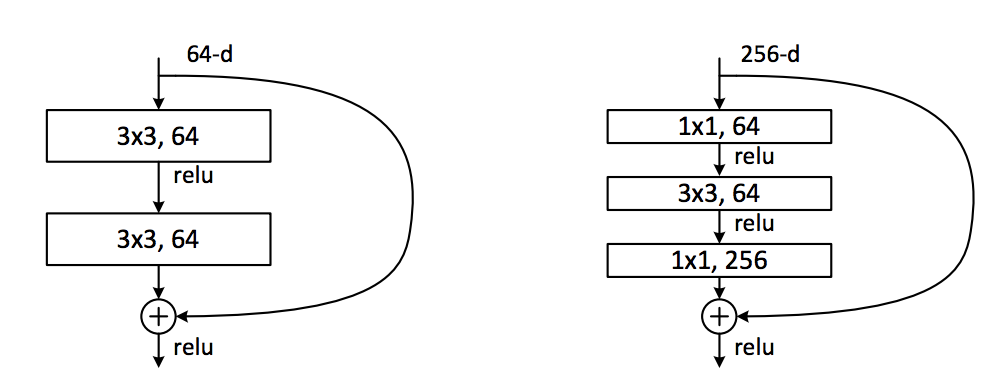

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
from typing import Type, List, Optional

In [17]:
from torchsummary import summary

In [18]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1) -> None:
        super(BasicBlock, self).__init__()

        # VGG의 철학을 따라 3 x 3 filter 사용
        self.conv1: nn.Conv2d = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1: nn.BatchNorm2d = nn.BatchNorm2d(planes)

        # 마찬가지로 3 x 3 filter 사용, 2번째 conv layer에서는 차원이 변하지 않음
        self.conv2: nn.Conv2d = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2: nn.BatchNorm2d = nn.BatchNorm2d(planes)

        ######################## ResNet의 핵심 부분 ######################################
        #
        # Mapping을 추가해 주어야 하는데, dimension이 변하는 부분을 고려해야 함.
        # (ResNet에서는 complexity를 유지하기 위해서 dimension이 변하는 경우에만 stride = 2로 변경)
        #
        # 1. stride == 1인 경우 : dimension이 변하지 않음 -> identity mapping 사용
        # 2. stride != 1인 경우 : dimension이 변하는 경우이므로 identity mapping을 사용할 수 없음
        #                        -> 1 x 1 convolution을 활용하여 차원을 맞추어 줌.
        #

        self.shortcut: nn.Sequential = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 실제 논문에서 사용한 방식과 거의 유사함 (shortcut 위치 등)
        out: torch.Tensor = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [19]:
class BottleNeck(nn.Module):
    expansion: int = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        super(BottleNeck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = F.relu(out + self.shortcut(x))
        return out


In [20]:
# Basic Block을 여러 개 붙여서 ResNet을 정의
# 앞서 정의한 Basic Block을 _make_layer() method에 넘겨서 이어붙이는 구조
# num_blocks에 [2, 2, 2, 2]를 넘겨주면 18-layer가 됨 (conv1 + 4 + 4 + 4 + 4 + FC)

class ResNet(nn.Module):
    def __init__(self, block: Type[nn.Module], num_blocks: List[int], num_classes: int = 2, init_weights: bool = True) -> None:
        # block: ResidualBlock or Bottleneck
        super().__init__()

        self.in_channels: int = 64

        self.conv1: nn.Sequential = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x: nn.Sequential = self._make_layer(block, 64, num_blocks[0], 1)
        self.conv3_x: nn.Sequential = self._make_layer(block, 128, num_blocks[1], 2)
        self.conv4_x: nn.Sequential = self._make_layer(block, 256, num_blocks[2], 2)
        self.conv5_x: nn.Sequential = self._make_layer(block, 512, num_blocks[3], 2)

        self.avg_pool: nn.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((1, 1))
        self.fc: nn.Linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block: Type[nn.Module], out_channels: int, num_blocks: int, stride: int) -> nn.Sequential:
        # 첫 번째 conv에서만 stride를 통해 차원을 변경해줄 수 있도록 지정
        # num_blocks = 3이라고 하면 building block 3개를 이어붙이므로 6개의 layer가 생기는 것
        # (단, 1번째 block의 conv1에만 stride를 적용하고 나머지는 1)
        strides: List[int] = [stride] + [1] * (num_blocks - 1)
        layers: List[nn.Module] = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output: torch.Tensor = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)  # FC 레이어
        return output

###구조

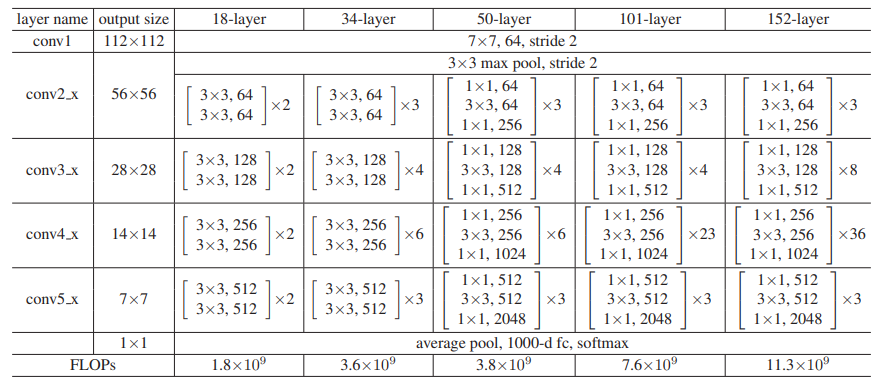

18, 34 layer는 Basicblock을 사용하고, 나머지는 Bottleneck block 을 사용합니다.

**최소 3개**의 모델을 구현해주세요! (당연히 resnet18은 제외)

f1 score의 추이에 따라 적절한 모델을 구현하여 이용해보세요.

In [21]:
def resnet18() -> ResNet:
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34() -> ResNet:
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50() -> ResNet:
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101() -> ResNet:
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152() -> ResNet:
    return ResNet(BottleNeck, [3, 8, 36, 3])

##Step 3. Train and Test

In [22]:
import os
import torch
from torch.optim import Optimizer
from sklearn.metrics import f1_score

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = resnet18() # 원하는 layer로 수정
model_name = 'resnet18' # model 이름도 맞춰서 바꿔주세요
net = net.to(device)
net = torch.nn.DataParallel(net)

learning_rate = 0.01
file_name = f'{model_name}_DogNCat.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=3e-4)

In [30]:
def train(epoch: int) -> None:
    print("------------------------------------------------------------")
    print('\nEpoch %d (train)' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print('\nBatch', str(batch_idx))
            print('Accuracy (train):', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Loss:', loss.item())

    print('\nTotal accuracy (train):', 100. * correct / total)
    print('Total loss:', train_loss)

In [25]:
def adjust_learning_rate(optimizer: Optimizer, epoch: int) -> None:
    # Learning Rate Scheduling
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [26]:
def test(epoch: int) -> float:
    print('\nEpoch: %d (test)' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100. * correct / total
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print('\nAccuracy (test):', accuracy)
    print('Test average loss:', loss / total)
    print('F1 Score (test):', f1)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return f1

In [45]:
# for epoch in range(0, 200):
f1_scores = []
for epoch in range(0, 2):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    f1 = test(epoch)
    f1_scores.append(f1)

------------------------------------------------------------

Epoch 0 (train)

Batch 0
Accuracy (train): 0.6875
Loss: 0.6159157156944275

Total accuracy (train): 57.8
Total loss: 44.272110283374786

Epoch: 0 (test)

Accuracy (test): 53.833333333333336
Test average loss: 0.028513548771540324
F1 Score (test): 0.4274966931216931
Model Saved!
------------------------------------------------------------

Epoch 1 (train)

Batch 0
Accuracy (train): 0.65625
Loss: 0.672319769859314

Total accuracy (train): 60.4
Total loss: 42.20354998111725

Epoch: 1 (test)

Accuracy (test): 61.0
Test average loss: 0.020949762960275013
F1 Score (test): 0.6088875022285611
Model Saved!


아래 셀의 결과가 0.5가 넘으면 됩니다 :)

model의 성능을 향상시키기 위해 hyperparemeter(epoch 수, batch size, learning rate 등등)를 조정하거나 model의 종류를 바꿔보는 등의 여러 시도를 해보세요!

In [46]:
# Print the final F1 score
print("\nFinal F1 Score:", f1_scores[-1])


Final F1 Score: 0.6088875022285611


**끝**